# 1. Setup

In [1]:
from time import time

from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
# from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression, SGDRegressor, BayesianRidge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import LinearSVR
from xgboost import XGBRegressor

from utils import *

# 2. Experiment

In [2]:
seed = 1234

## 2.1. Prepare dataset for modeling

In [3]:
trips = pd.read_parquet('../data/trips.parquet').disp()

722,247 rows x 31 cols; Memory: 50.3 MiB


,RawTime,Time,Distance,Speed,LogDistance,Mode,Purpose,HomeBased,VehType,Weekend,...,MSAKind,UrbanO,UrbanD,PopDensityO,PopDensityD,HouseDensityO,HouseDensityD,EmpDensityO,EmpDensityD,Weight
,<int64>,<float64>,<float64>,<float64>,<float64>,<category>,<category>,<category>,<category>,<category>,...,<category>,<category>,<category>,<category>,<category>,<category>,<category>,<category>,<category>,<float64>
0,15,16.182075,8.439379,31.291583,3.926362,Drive,Social,Yes,Car,No,...,Small,Suburban,Suburban,Mid,Low,Mid,Low,Mid,Low,1.0


In [4]:
X = pd.get_dummies(trips.select_dtypes(CAT), prefix_sep='__')

In [5]:
idx = Series(trips.index).sample(frac=1, random_state=seed).values
idx = D(zip(['train', 'val', 'test'], np.split(
    idx, [int(0.7 * len(idx)), int(0.85 * len(idx))])))
print({k: len(v) for k, v in idx.items()})

{'train': 505572, 'val': 108337, 'test': 108338}


## 2.2. Targets & measures

In [6]:
targets = {'LogDistance': (2, 5), 'Duration': (0, 90)}
# targets = {'Distance': 100, 'Duration': 90}

## 2.3. Test models

In [7]:
models = (
    ## Linear models
    ('Linear Regression', LinearRegression(), D(
        fit_intercept=[True, False],
    )),
    ('Bayesian Ridge',
     BayesianRidge(max_iter=1000),
     D(alpha_1=[.5e-6, 1e-6, 2e-6],
       alpha_2=[.5e-6, 1e-6, 2e-6],
       lambda_1=[.5e-6, 1e-6, 2e-6],
       lambda_2=[.5e-6, 1e-6, 2e-6],
    )),
    ('SGD Regression', SGDRegressor(max_iter=1000), D(
        alpha=[1e-05, 0.0001, 0.001, 0.01],
        l1_ratio=[0.1, 0.15, 0.2, 0.3],
        penalty=['l2', 'elasticnet'],
    )),
    ## Kernel models
    ('Linear SVR', LinearSVR(dual='auto', max_iter=50_000), D(
        C=[0.5, 0.75, 1.0, 1.25, 1.5],
        epsilon=[0, 0.1, 0.2],
        loss=['epsilon_insensitive', 'squared_epsilon_insensitive']
    )),
    ## Decision tree models
    ('Random Forest',
     RandomForestRegressor(n_jobs=6, random_state=seed),
     D(n_estimators=[100, 200, 300], max_depth=[10, 20, 30, 40],
    )),
    ('Light Gradient Boost',
     LGBMRegressor(n_jobs=6, force_row_wise=True, verbosity=-1,
                   random_state=seed, num_leaves=1000),
     D(learning_rate=[0.05, 0.1, 0.5], max_depth=[10, 20, 30, 40],
       n_estimators=[100, 200, 500, 750],
    )),
    ('Extreme Gradient Boost',
     XGBRegressor(n_jobs=6, verbosity=0, random_state=seed),
     D(booster=['gbtree', 'gblinear'], learning_rate=[0.05, 0.1, 0.5],
       n_estimators=[100, 200, 500, 750],
    )),
)

## 2.4. Select best estimators using CV

In [ ]:
def cross_validate(X=X, data=trips, idx=idx, targets=targets,
                   models=models, njobs=1, overwrite=False):
    outpath = Path('../data/model_validation.pickle')
    if outpath.exists() and not overwrite:
        return pd.read_pickle(outpath)
    Xval = X.loc[idx['val']]
    wts = data.Weight.loc[idx['val']]
    res = []
    pbar = tqdm(list(it.product(models, targets.items())))
    for (name, model, params), (target, rng) in pbar:
        pbar.set_description(f'{target}: {name}')
        t = time()
        yval = data[target].loc[idx['val']].clip(*rng)
        cv = GridSearchCV(model, params, cv=2, n_jobs=njobs, scoring='r2')
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            cv.fit(Xval, yval, sample_weight=wts)
        res.append(D(target=target, family=name, model=cv.best_estimator_,
                     params=cv.best_params_, r2=cv.best_score_,
                     runtime=time() - t))
    res = Pdf(res)
    res.to_pickle(mkfile(outpath))
    return res

cv_df = cross_validate(njobs=12, overwrite=1).disp() # t=9:17

  0%|          | 0/14 [00:00<?, ?it/s]

14 rows x 6 cols; Memory: 0.0 MiB


,target,family,model,params,r2,runtime
,<object>,<object>,<object>,<object>,<float64>,<float64>
0,LogDistance,Linear Regression,LinearRegression(fit_intercept=False),{'fit_intercept': False},0.309514,2.056274


## 2.5. Compare inter-model performance

In [ ]:
metrics = D(mae=mean_absolute_error, mape=mean_absolute_percentage_error, mse=mean_squared_error)

In [ ]:
def train_test_models(cv_df=cv_df, X=X, data=trips, idx=idx, targets=targets,
                      metrics=metrics, overwrite=False):
    outpath = Path('../data/model_comparison.pickle')
    if outpath.exists() and not overwrite:
        return pd.read_pickle(outpath)
    res = []
    Xtrain, Xtest = [X.loc[idx[x]] for x in ['train', 'test']]
    wtrain, wtest = [data.Weight.loc[idx[x]] for x in ['train', 'test']]
    pbar = tqdm(list(cv_df.iterrows()))
    for _, r in pbar:
        pbar.set_description(f'{r.target}: {r.model}')
        t = time()
        y = data[r.target].clip(*targets[r.target])
        y = 10 ** (y - 3) if 'Log' in r.target else y
        ytrain, ytest = y.loc[idx['train']], y.loc[idx['test']]
        if hasattr(r.model, 'n_jobs') and isinstance(r.model.n_jobs, int):
            r.model.n_jobs = -1
        r.model.fit(Xtrain, ytrain, sample_weight=wtrain)
        row = D(target=r.target.lstrip('Log'), family=r.family,
                model=r.model, params=r.params, r2=r.r2)
        ypred = r.model.predict(Xtest)
        for metric, func in metrics.items():
            row[metric] = func(ytest, ypred, sample_weight=wtest)
        res.append(row | D(runtime=time() - t))
    res = Pdf(res)
    res.to_pickle(mkfile(outpath))
    return res

res_fit = train_test_models(overwrite=1).disp() # t=3:26
# x = train_test_models(overwrite=1); x # t=9:10

  0%|          | 0/14 [00:00<?, ?it/s]

14 rows x 9 cols; Memory: 0.0 MiB


,target,family,model,params,r2,mae,mape,mse,runtime
,<object>,<object>,<object>,<object>,<float64>,<float64>,<float64>,<float64>,<float64>
0,Distance,Linear Regression,LinearRegression(fit_intercept=False),{'fit_intercept': False},0.309514,9.432825,3.464226,227.696913,1.571001


In [ ]:
(res_fit.assign(family=ordered_factor(res_fit.family))
 .drop(columns=['model'])
 .melt(['target', 'family'], var_name='metric')
 .assign(metric=lambda x: x.metric.str.upper())
 .pipe(lambda df: df[df.metric.isin(['R2', 'MAE', 'MAPE', 'MSE'])])
 .rename(columns=str.title)
 .pivot_table('Value', 'Family', ['Target', 'Metric'])
 .reset_index())

Target                  Family  Distance                                  \
Metric                               MAE      MAPE         MSE        R2   
0            Linear Regression  9.432825  3.464226  227.696913  0.309514   
1               Bayesian Ridge  9.427557  3.460219   227.69569  0.309574   
2               SGD Regression  9.540185  3.549276   227.90737  0.311783   
3                   Linear SVR  9.458432  3.483788  227.704219  0.311047   
4                Random Forest  8.557426  2.331809  197.655327  0.402635   
5         Light Gradient Boost  8.413315  2.224674  197.375964  0.426249   
6       Extreme Gradient Boost  8.467827  2.262257  199.405959  0.436503   

Target   Duration                                  
Metric        MAE      MAPE         MSE        R2  
0       11.228362  1.251545  253.324012  0.094623  
1       11.228436  1.251599  253.325293  0.094735  
2       11.242298  1.254612  253.511023  0.096133  
3       11.228398  1.251514  253.325574  0.094746  
4       10.728005   1.16864  235.035699  0.153747  
5       10.416429   1.09675  224.418713  0.169806  
6        10.47529  1.105714  226.366453  0.179556

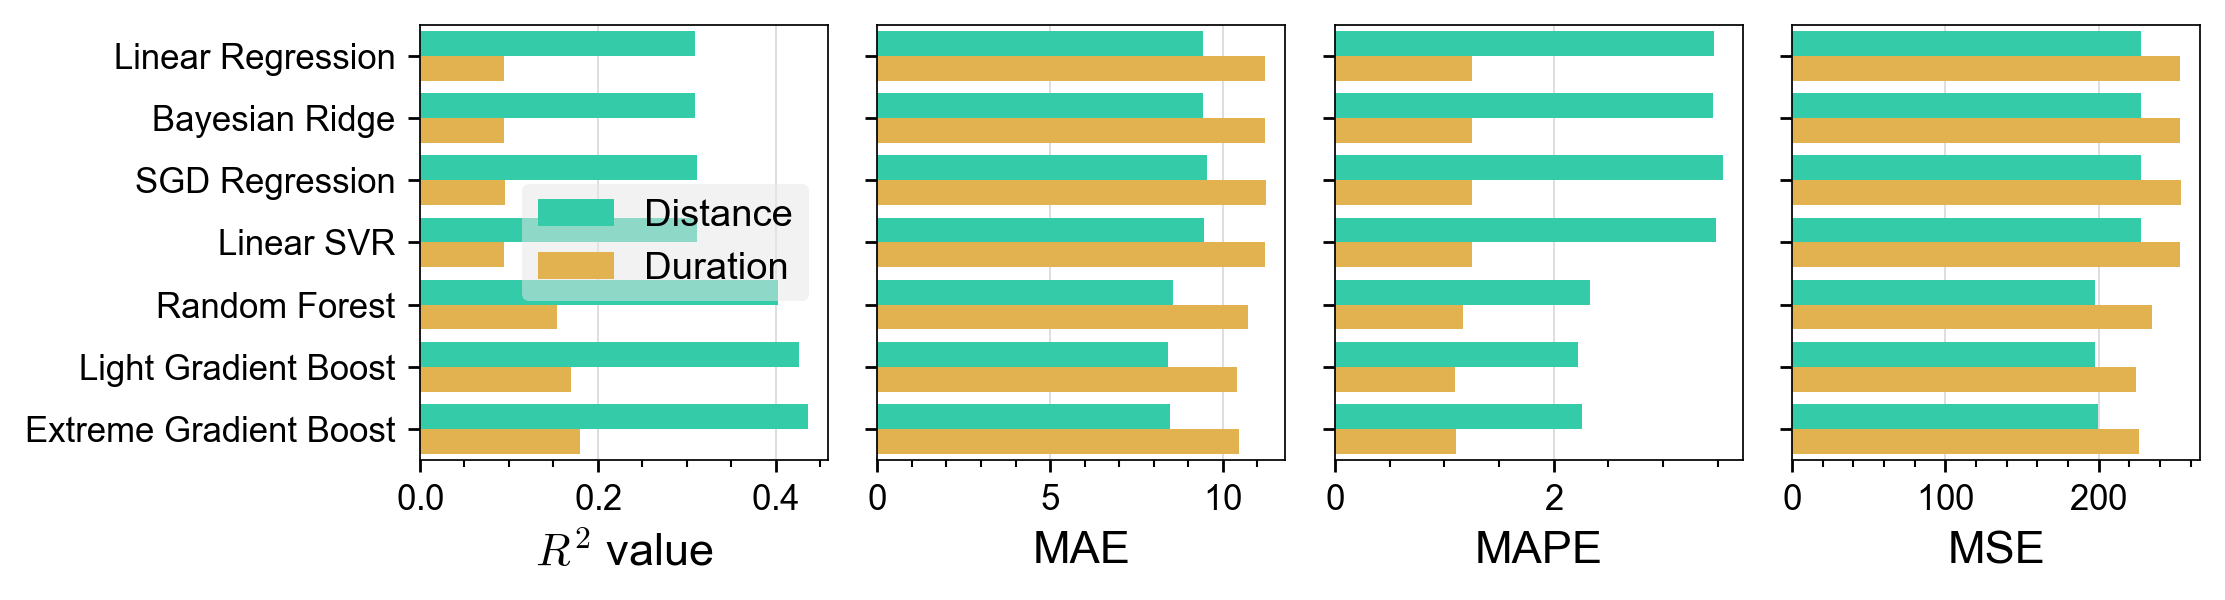

In [ ]:
def fig_compare_models(res, size=(9, 2.5), dpi=150):
    _, axes = plt.subplots(1, 4, figsize=size, dpi=dpi)
    for i, (metric, label) in enumerate([
            # ('r2', '$R^2$ value'), ('mae', 'MAE'), ('mse', 'MSE')]):
            ('r2', '$R^2$ value'), ('mae', 'MAE'), ('mape', 'MAPE'), ('mse', 'MSE')]):
        ax = pplot(axes[i], xlab=label, yminor=0)
        sns.barplot(res, ax=ax, x=metric, y='family', hue='target', palette='turbo')
        ax.set_ylabel('')
        if i == 0:
            ax.legend_.set_title(None)
        if i > 0:
            ax.legend_.remove()
            ax.set_yticklabels([])
    plt.tight_layout()
    imsave('Comparison of regression model performance')

fig_compare_models(res_fit, dpi=250)

## 2.6. Fit the best model

In [ ]:
# t=0:06
best_model_kind = 'Light Gradient Boost'
models = {} # finally selected models
Xtrain, Xtest = X.loc[idx['train']], X.loc[idx['test']]
for target in tqdm(['Distance', 'Duration']):
    params = (res_fit.query(f'family=="{best_model_kind}" & '
                            f'target=="{target}"')).params.iloc[0]
    model = LGBMRegressor(**(params | D(max_depth=-1)),
                          random_state=seed, n_jobs=-1, verbosity=-1)
    ytrain = trips[target].loc[idx['train']]
    model.fit(Xtrain, ytrain)
    models[target] = model
save_pickle(models, '../data/selected_models.pickle')
models['Duration']

  0%|          | 0/2 [00:00<?, ?it/s]

LGBMRegressor(learning_rate=0.05, n_jobs=-1, random_state=1234, verbosity=-1)

In [ ]:
res_fit.query('target=="Duration" & family=="Light Gradient Boost"')

,target,family,model,params,r2,mae,mape,mse,runtime
11,Duration,Light Gradient Boost,"LGBMRegressor(force_row_wise=True, learning_ra...","{'learning_rate': 0.05, 'max_depth': 10, 'n_es...",0.169806,10.416429,1.09675,224.418713,5.48686


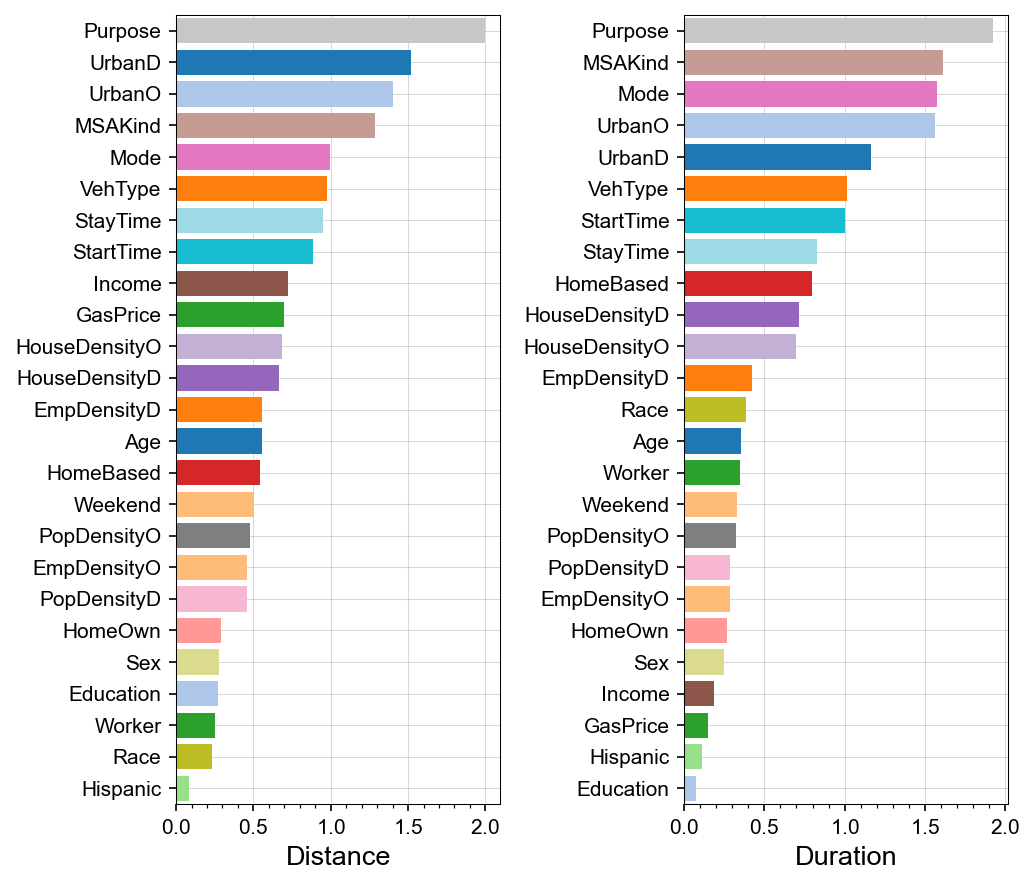

In [ ]:
def plot_feature_importance(models, size=(7, 6), dpi=150):
    _, axes = plt.subplots(1, 2, figsize=size, dpi=dpi)
    for i, (target, model) in enumerate(models.items()):
        df = Pdf(D(factor=model.feature_name_, imp=normalize(model.feature_importances_)))
        df['feature'], df['level'] = list(zip(*df.factor.str.split('__')))
        df = df.groupby('feature')['imp'].sum().sort_values().reset_index()
        df['color'] = df.feature.astype(CAT).cat.codes.map(dict(enumerate(
            sns.color_palette('tab20', df.feature.nunique())))).apply(mpl.colors.to_hex)
        ax = pplot(axes[i], xlab=target, yminor=0)
        ax.set_ylim(-0.5, len(df) - 0.5)
        ax.barh(df.feature, df.imp, color=df.color);
    plt.tight_layout()

plot_feature_importance(models)